## Look into the dataset

In [1]:
!pip3 install git+https://github.com/fastai/fastai.git

  Created wheel for fastai: filename=fastai-2.2.8-cp37-none-any.whl size=192313 sha256=3d5b878e0297bbc29925d7f9010d03e13e8da8b891f13f159a99aaac225b10e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-3uqwvljd/wheels/cf/46/39/b2d08762125ed2376861976ab2c4ac30c029b86e375735d9b8
Successfully built fastai
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
import sys
sys.version

'3.7.10 (default, Feb 20 2021, 21:17:23) \n[GCC 7.5.0]'

### Loading the data

$E$ and $p_T$ are log transformed whereas $\eta$ and $\phi$ are scaled down by $\pi$

In [3]:
import pandas as pd
import csv
import numpy as np

# Path to the given dataset csv
dataset_path = '/content/dataset.csv'

with open(dataset_path) as f:
    r = csv.reader(f, delimiter=';')
    E1s = []
    pt1s = []
    eta1s = []
    phi1s = []
    
    for _, _, _, _, _, *vals in r:
        for i,item in enumerate(vals,1):
            if 'j' not in item: continue
            items = item.split(',')
            obj1, E1, pt1, eta1, phi1 = items
            E1s.append(np.log(float(E1)))
            pt1s.append(np.log(float(pt1)))
            eta1s.append(float(eta1)/np.pi)
            phi1s.append(float(phi1)/np.pi)

data = {'E': E1s, 'pt':pt1s, 'eta':eta1s, 'phi':phi1s}
df = pd.DataFrame(data, columns=data.keys())
print(df.describe())
print(df.info())

                  E            pt           eta           phi
count  22661.000000  22661.000000  22661.000000  22661.000000
mean      12.494736     11.790787      0.003815     -0.003943
std        1.056825      1.131862      0.479411      0.576237
min       10.101346     10.002722     -1.550204     -0.999990
25%       11.680497     10.767270     -0.304042     -0.503811
50%       12.581144     11.709487      0.004326     -0.002289
75%       13.347631     12.806723      0.314576      0.491445
max       15.300219     14.553086      1.512952      0.999878
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22661 entries, 0 to 22660
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   E       22661 non-null  float64
 1   pt      22661 non-null  float64
 2   eta     22661 non-null  float64
 3   phi     22661 non-null  float64
dtypes: float64(4)
memory usage: 708.3 KB
None


### Splitting Dataset for Training and Validation

18k samples are used as training values and remaining are used for validation.

In [4]:
splitIdx = 18000
df_train = df[:splitIdx]
df_test = df[splitIdx:]
print(df_train.describe())
print(df_test.describe())

                  E            pt           eta           phi
count  18000.000000  18000.000000  18000.000000  18000.000000
mean      12.491800     11.790967      0.005297     -0.004675
std        1.057964      1.133202      0.478443      0.577177
min       10.101346     10.002722     -1.550204     -0.999990
25%       11.678603     10.765555     -0.302034     -0.507321
50%       12.582711     11.713983      0.007108     -0.004254
75%       13.344932     12.805257      0.312996      0.491112
max       15.300219     14.553086      1.512952      0.999878
                 E           pt          eta          phi
count  4661.000000  4661.000000  4661.000000  4661.000000
mean     12.506073    11.790090    -0.001907    -0.001116
std       1.052452     1.126791     0.483137     0.572648
min      10.129312    10.022181    -1.524997    -0.998767
25%      11.693354    10.774463    -0.314153    -0.490073
50%      12.575679    11.699712    -0.007462     0.005084
75%      13.360514    12.812629     

### Plotting the dataset

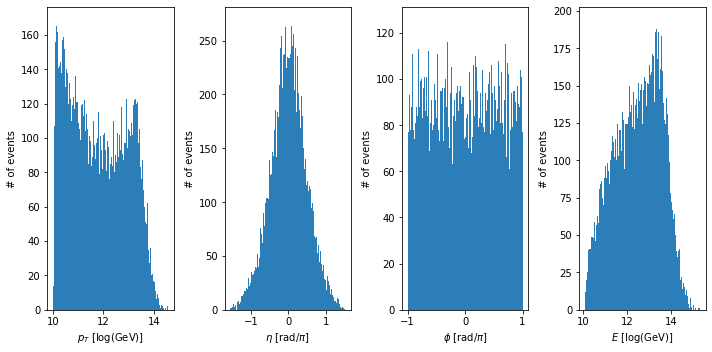

In [5]:
import matplotlib.pyplot as plt

unit_list = ['[log(GeV)]', r'[rad/$\pi$]', r'[rad/$\pi$]', '[log(GeV)]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']

branches=["pt","eta","phi","E"]

n_bins = 200

f,a = plt.subplots(1,4, figsize=(10, 5))
a = a.ravel()

for kk, ax in enumerate(a):
    n_hist_data, bin_edges, _ = ax.hist(df_train[branches[kk]], label='Input', alpha=0.95, bins=n_bins)
    ax.set_xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    ax.set_ylabel('# of events')
plt.tight_layout()
plt.show()

$\eta$ seems to follow a normal distribution, $\phi$ is pretty evenly distributed in the domain, $log(p_T)$ seems to fit in a bimodal distribution and $log(E)$ can be a skewed normal distribution.

## Setting up the network

### Preparing the data

Adding the two datasets as TensorDatasets to PyTorch Dataloader

For data compression using autoencoders, the output of decoder and input of encoder must converge to equality under proper error limits.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

train_x = df_train
test_x = df_test
train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

In [8]:
bs = 512

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

### Preparing the network

The network will compress the "four-momentum" of the jet particles from 4 values down to 3 values and then decode it back to 4 values to ensure minimum information loss.

I am using the example notebook network as it is without any changes for now (except the class name)


In [9]:
class AE_3D_200_tanh(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_tanh, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    # this function compresses the data to 3 variable output
    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    # this function decompresses the 3-variable encoded values to the "four-momentum" of jet particle
    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    # performs the encoding on input and decodes it back. This should ideally be an identity function.
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

model = AE_3D_200_tanh()

We now have to pick a loss function - MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize. 

In [10]:
from fastai.metrics import mse
from fastai.callback.data import CudaCallback
loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
#true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=[recorder, CudaCallback])
#was: learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

### Learning Rate

Learning rate with the minimum loss: 0.03630780577659607
Learning rate with the steepest gradient: 0.005248074419796467


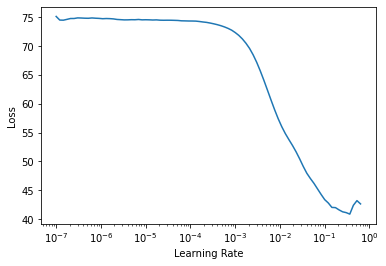

In [11]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

### Training

I choose maximum learning rate as $lr\_min / 10$ and further reduce LR on plateau of validation loss to avoid overfitting and fast learning at same time.

In [12]:
import time
from fastai.callback.tracker import *

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(n_epoch=200, lr_max=lr_min/10.0, cbs=ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2))
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 67.09518432617188, 60.28409957885742, '00:00']
[0, 67.09518432617188, 60.28409957885742, '00:00']
[1, 55.246543884277344, 39.95924377441406, '00:00']
[1, 55.246543884277344, 39.95924377441406, '00:00']
[2, 39.58370590209961, 19.714000701904297, '00:00']
[2, 39.58370590209961, 19.714000701904297, '00:00']
[3, 24.763071060180664, 7.8750410079956055, '00:00']
[3, 24.763071060180664, 7.8750410079956055, '00:00']
[4, 14.111189842224121, 2.7997374534606934, '00:00']
[4, 14.111189842224121, 2.7997374534606934, '00:00']
[5, 7.598886489868164, 1.0621498823165894, '00:00']
[5, 7.598886489868164, 1.0621498823165894, '00:00']
[6, 4.078959941864014, 0.7408028841018677, '00:00']
[6, 4.078959941864014, 0.7408028841018677, '00:00']
[7, 2.3520114421844482, 0.738571286201477, '00:00']
[7, 2.3520114421844482, 0.738571286201477, '00:00']
[8, 1.519620418548584, 0.7349541187286377, '00:00']
[8, 1.519620418548584, 0.7349541187286377, '00:00']
Epoch 8: reducing lr to 4.1490498971955765e-05
[9, 1.117685198

Then we plot the loss as a function of batches and epochs to check if we reach a plateau.

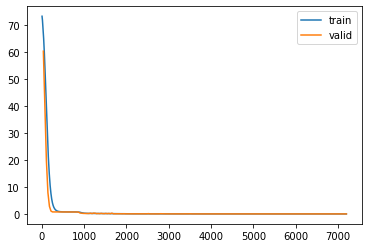

In [13]:
recorder.plot_loss()

Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well...if it has not trained as well (note the pesky 0-mass peak above...) then it's going to be a bit higher.

In [14]:
learn.validate()

(#1) [0.0004048749397043139]

Let's plot all of this, with ratios (thanks to code by Erik Wallin in example notebook). I have changed the plots to come in different columns rather than span multiple rows for a better visualization.

## Plotting the outputs of the network

Lazy-save of our output files (they'll also be on screen)

In [15]:
import os
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

A function in case we want to un-normalize and get back to physical quantities...

In [16]:
def custom_unnormalize(df):
    df['eta'] = df['eta'] * np.pi
    df['phi'] = df['phi'] * np.pi
    df['E'] = np.exp(df['E'])
    df['pt'] = np.exp(df['pt'])
    return df

Make the histograms from the dataset...

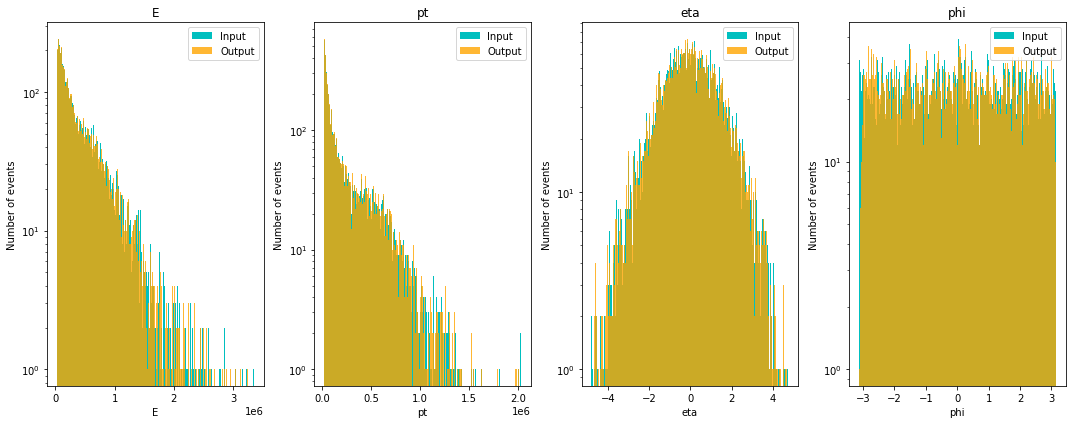

In [19]:
import numpy as np
import matplotlib.pyplot as plt

plt.close('all')

line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

save = True # Option to save figure

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(df_test[idxs[0]:idxs[1]].values, dtype=torch.float)
#data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float).double()
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=df_test.columns)
pred_df = pd.DataFrame(pred, columns=df_test.columns)

unnormalized_data_df = custom_unnormalize(data_df)
unnormalized_pred_df = custom_unnormalize(pred_df)    
    
alph = 0.8
n_bins = 200
f,a = plt.subplots(1,4, figsize=(15, 6))
a = a.ravel()

for kk, ax in enumerate(a):
    # plt.figure()
    n_hist_data, bin_edges, _ = ax.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = ax.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    ax.set_title(df_test.columns[kk])
    ax.set_xlabel(df_test.columns[kk])
    ax.set_ylabel('Number of events')
    # ms.sciy()
    ax.set_yscale('log')
    ax.legend()
plt.tight_layout()

if save:
    plt.savefig(os.path.join(save_dir,'OutputHist.png'))

In [20]:
def getRatio(bin1,bin2):
    bins = []
    for b1,b2 in zip(bin1,bin2):
        if b1==0 and b2==0:
            bins.append(0.)
        elif b2==0:
            bins.append(None)
        else:
            bins.append((float(b2)-float(b1))/b1)
    return bins   

rat = getRatio(n_hist_data,n_hist_pred)
print(rat)

[-0.967741935483871, -0.7777777777777778, -0.5454545454545454, -0.4230769230769231, -0.07142857142857142, 1.0, 0.13636363636363635, 0.125, 0.15, 0.7142857142857143, 0.25, 0.3157894736842105, 0.09375, 0.3684210526315789, 0.43478260869565216, 0.08695652173913043, 0.625, 1.1333333333333333, 0.07692307692307693, -0.2903225806451613, -0.2222222222222222, 0.17647058823529413, 0.10526315789473684, 0.15384615384615385, -0.25, 0.043478260869565216, 0.0, 0.0625, -0.038461538461538464, 0.25, -0.18518518518518517, -0.09090909090909091, 0.6875, -0.42857142857142855, 0.08695652173913043, -0.13043478260869565, 0.19230769230769232, 0.09523809523809523, -0.13793103448275862, 0.4166666666666667, 0.0, -0.37037037037037035, 0.3333333333333333, -0.30434782608695654, 0.10526315789473684, 0.0, 0.13043478260869565, -0.2903225806451613, 0.038461538461538464, 0.4, 0.16, -0.3783783783783784, 0.4, -0.21739130434782608, 0.3333333333333333, -0.20833333333333334, 0.0, -0.11538461538461539, 0.1111111111111111, 0.0909